## 1.	Dataset Characteristics and Exploratory Data Analysis

**Analysis of CIC-IDS 2017 Dataset based on the percentages of attack types**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df_monday = pd.read_csv("./data_files/Monday-WorkingHours.pcap_ISCX.csv")
df_tuesday = pd.read_csv("./data_files/Tuesday-WorkingHours.pcap_ISCX.csv")
df_wednesday = pd.read_csv("./data_files/Wednesday-workingHours.pcap_ISCX.csv")
df_thursday_afternoon = pd.read_csv("./data_files/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_thursday_morning= pd.read_csv("./data_files/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_friday_afternoon_ddos = pd.read_csv("./data_files/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_friday_afternoon_portscan = pd.read_csv("./data_files/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_friday_morning = pd.read_csv("./data_files/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_monday.columns = df_monday.columns.str.strip()
df_tuesday.columns = df_tuesday.columns.str.strip()
df_wednesday.columns = df_wednesday.columns.str.strip()
df_thursday_afternoon.columns = df_thursday_afternoon.columns.str.strip()
df_thursday_morning.columns = df_thursday_morning.columns.str.strip()
df_friday_afternoon_ddos.columns = df_friday_afternoon_ddos.columns.str.strip()
df_friday_afternoon_portscan.columns = df_friday_afternoon_portscan.columns.str.strip()
df_friday_morning.columns = df_friday_morning.columns.str.strip()


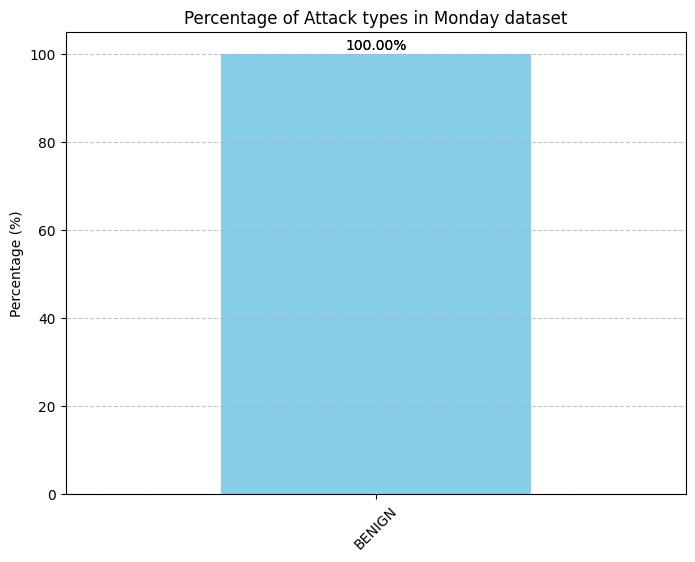

In [3]:
df_monday['Label'].unique()
percentages = df_monday['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Monday dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()



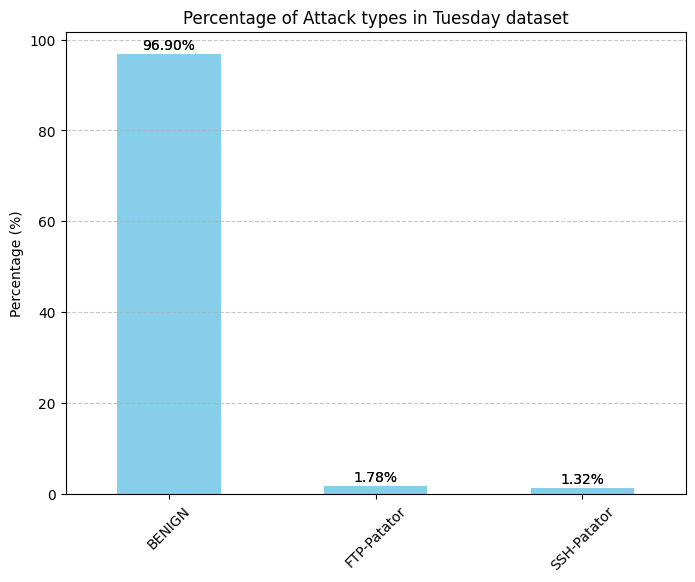

In [4]:
df_tuesday.columns
df_tuesday['Label'].unique()
percentages = df_tuesday['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Tuesday dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()

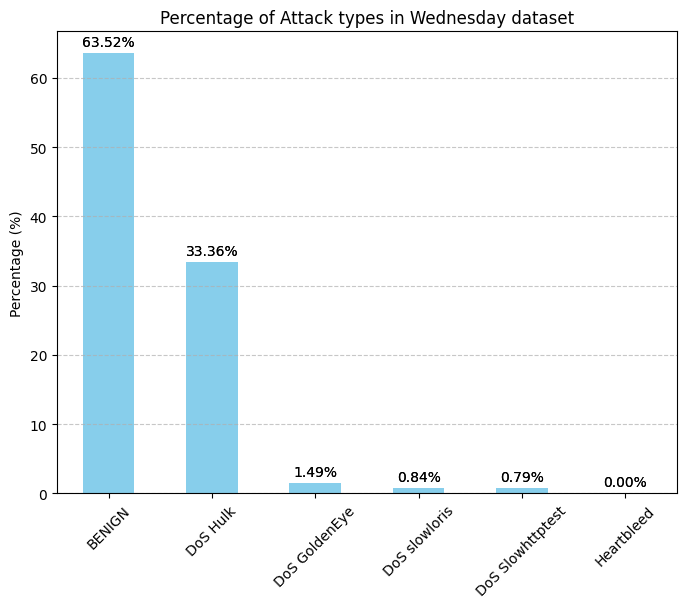

In [5]:
df_wednesday.columns
df_wednesday['Label'].unique()
percentages = df_wednesday['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Wednesday dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()


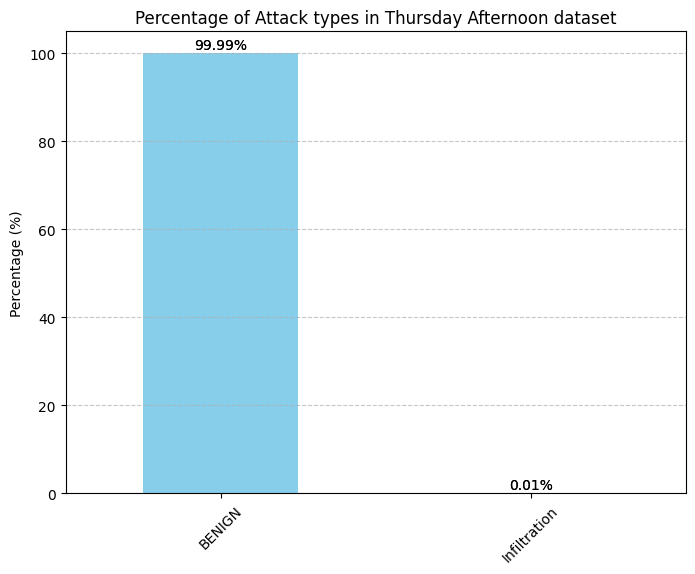

In [6]:
df_thursday_afternoon.columns
df_thursday_afternoon['Label'].unique()
percentages = df_thursday_afternoon['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Thursday Afternoon dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()


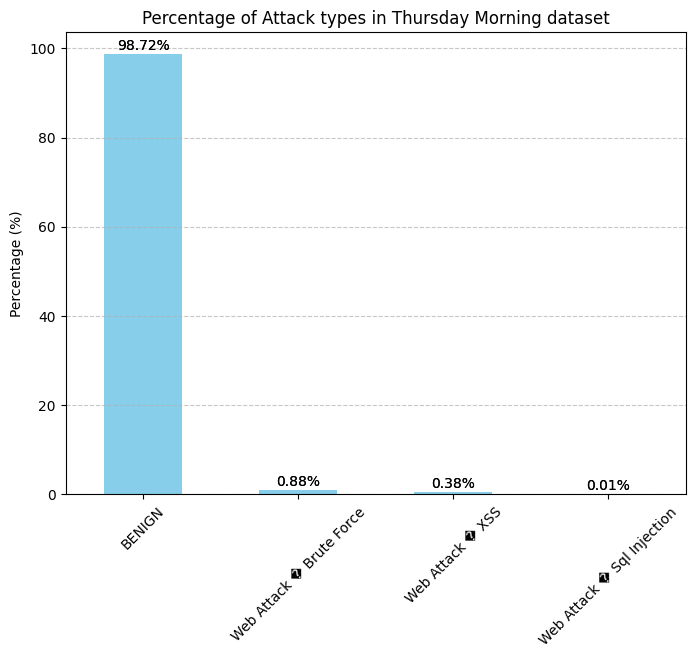

In [7]:
df_thursday_morning.columns
df_thursday_morning['Label'].unique()
percentages = df_thursday_morning['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Thursday Morning dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()


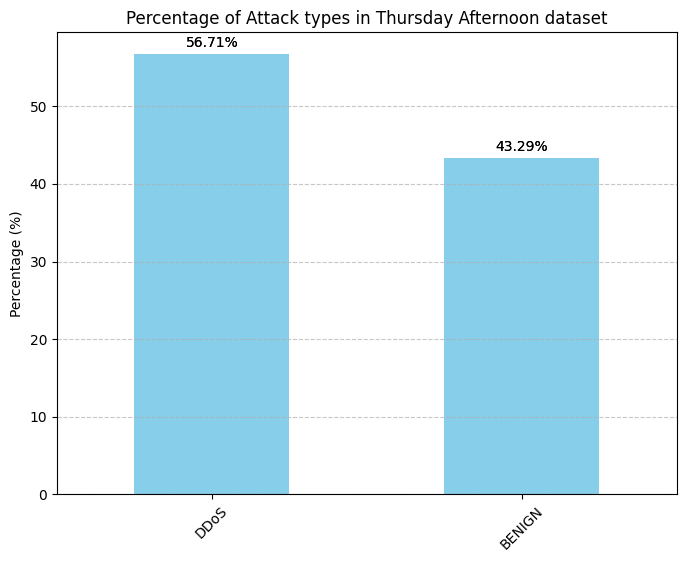

In [8]:
df_friday_afternoon_ddos.columns
df_friday_afternoon_ddos['Label'].unique()
percentages = df_friday_afternoon_ddos['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Thursday Afternoon dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()

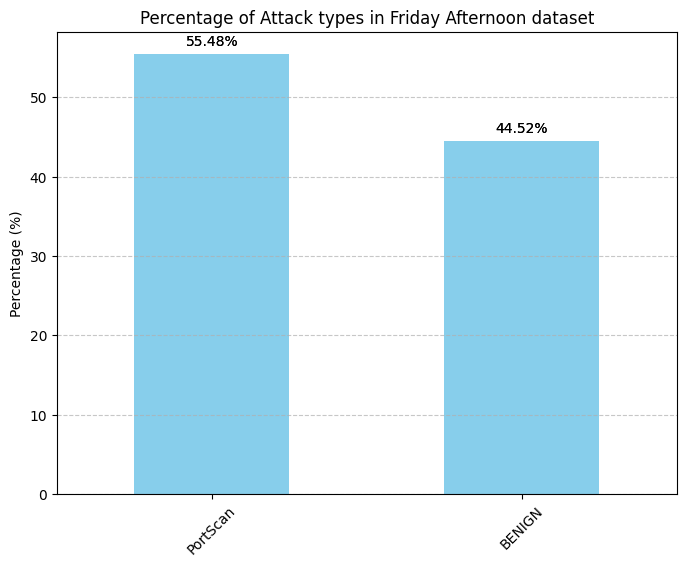

In [9]:
df_friday_afternoon_portscan.columns
df_friday_afternoon_portscan['Label'].unique()
percentages = df_friday_afternoon_portscan['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Friday Afternoon dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()

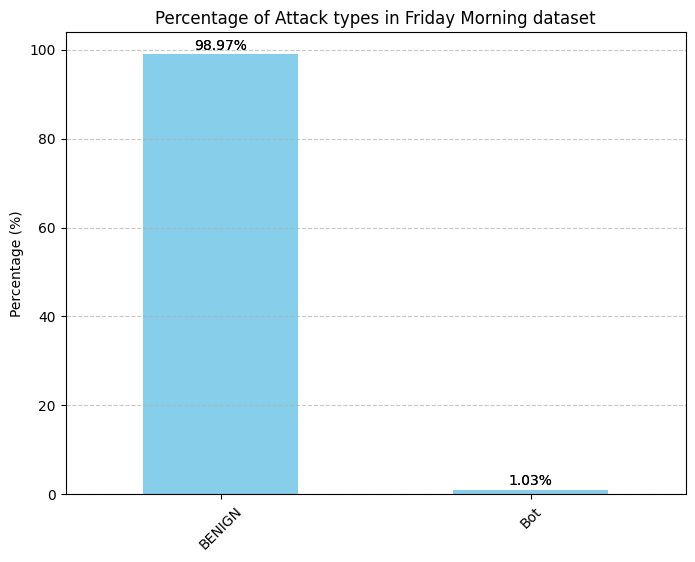

In [10]:
df_friday_morning.columns
df_friday_morning['Label'].unique()
percentages = df_friday_morning['Label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
bars = percentages.plot(kind='bar', color='skyblue')
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Attack types in Friday Morning dataset')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')


plt.show()

**2. View Data and Show Analysis on Rows and Columns**

In [11]:
data_list  =[df_monday, df_tuesday, df_wednesday, df_thursday_morning, df_thursday_afternoon, df_friday_morning, df_friday_afternoon_ddos, df_friday_afternoon_portscan]  
print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

data = pd.concat(data_list)
#data.columns = data.columns.str.strip()
rows, cols = data.shape

print('After concatinating the datasets:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

Data dimensions: 
Data1 -> 529918 rows, 79 columns
Data2 -> 445909 rows, 79 columns
Data3 -> 692703 rows, 79 columns
Data4 -> 170366 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 191033 rows, 79 columns
Data7 -> 225745 rows, 79 columns
Data8 -> 286467 rows, 79 columns
After concatinating the datasets:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [12]:

# Convert labels to numeric: Benign -> 1, everything else -> 0
data['Label'] = data['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0)
# Types of attacks & normal instances (BENIGN)
data['Label'].value_counts()

Label
1    2273097
0     557646
Name: count, dtype: int64